## Conformity Scores

**Conventions.** We use standard notation from the literature:

* $0<\alpha<1$ denotes the **risk level**. The corresponding **confidence level** is $1-\alpha$.
* *Calibrate* and *calibration* are equivalent to *conformalize* and *conformalization*.

### Notation and symbols

Let $(X,Y)\in\mathcal{X}\times\mathbb{R}$ be a random pair and let $\{(X_i,Y_i)\}_{i=1}^n$ be i.i.d. calibration data, exchangeable with a future pair $(X_{n+1},Y_{n+1})$.


* $X \in \mathcal{X}$ is a feature vector or covariate, drawn from some feature space $\mathcal{X}$ (for example, $\mathbb{R}^d$ if we are working with $d$-dimensional real-valued features).
* $Y \in \mathbb{R}$ is the response or label, which here is assumed to be real-valued (for regression tasks).
* The pair $(X,Y)$ belongs to the Cartesian product $\mathcal{X}\times \mathbb{R}$, i.e., an input–output pair.

The following are used in defining conformity scores and conformal prediction sets:

* $\hat{\mu}:\mathcal{X}\to\mathbb{R}$ is a point predictor of $Y$ given $X$. Here $\mu$ is the population regression function and $\hat{\mu}$ is its estimate.
* $\hat{\sigma}:\mathcal{X}\to(0,\infty)$ is a learned scale model for residual magnitude. Here $\sigma$ is the residual scale and $\hat{\sigma}$ is its estimate.
* $s:\mathcal{X}\times\mathbb{R}\to\mathbb{R}$ is a conformity score. Larger $s(x,y)$ means worse agreement between $y$ and the model at $x$.

* **Random variables and data pairs:**

  * $(X,Y) \in \mathcal{X}\times\mathbb{R}$ denotes a **generic random pair** drawn from the underlying distribution.
  * $(X_i,Y_i)$ are i.i.d. samples of such pairs, used for calibration.
  * $(X_{n+1},Y_{n+1})$ is the future (test) pair, exchangeable with the calibration data.

* **Fixed inputs and values:**

  * Lowercase $x \in \mathcal{X}$ and $y \in \mathbb{R}$ are **realized values** of the random variables $X$ and $Y$.
  * For example, the conformity score is written $s(x,y)$ because it evaluates the discrepancy at a specific feature–label pair, not a random one.
  
---

## Definition of the empirical quantile

For a finite multiset $A = \{a_1, \dots, a_n\}$, define the empirical distribution function (EDF):

$$
F_n(t) \;=\; \frac{1}{n}\sum_{i=1}^n \mathbf{1}\{a_i \le t\}, \qquad t \in \mathbb{R}.
$$

* This is a right-continuous, non-decreasing step function.
* At any real number $t$, $F_n(t)$ is the fraction of the $a_i$'s that are less than or equal to $t$.

Then, the quantile definition is

$$
q_{1-\alpha}(A) = \inf \{t \in \mathbb{R} : F_n(t) \ge 1-\alpha\}.
$$

Here:

* $t$ is just a *real threshold* that we scan across the real line.
* The set $\{t : F_n(t) \ge 1-\alpha\}$ consists of all thresholds at which at least a $1-\alpha$ fraction of the data is below or equal to $t$.
* Taking the infimum means we choose the smallest such threshold.

This is the mathematical definition of the empirical $(1-\alpha)$-quantile.

### Connection to order statistics

If we sort the data in ascending order, $a_{(1)} \le a_{(2)} \le \dots \le a_{(n)}$, then it is a standard fact that

$$
q_{1-\alpha}(A) = a_{(k)}, \quad \text{where } k = \min\{j : j/n \ge 1-\alpha\}.
$$

In practice, conformal prediction often uses

$$
k = \lceil (1 - \alpha)(n+1) \rceil,
$$

which is called the **“higher” order statistic**. This choice ensures validity under exchangeability, because it is slightly conservative compared to just using $k = \lceil (1-\alpha)n \rceil$.

### Intuition for $t$

* Think of $t$ as a cutoff.
* We are asking: "what is the smallest real number such that at least $(1-\alpha)$ fraction of the calibration scores are below it?"
* That cutoff is the empirical quantile.

So $t$ is not a fixed number beforehand. It is a variable ranging over all real values. The infimum in the definition ensures we pick the *leftmost threshold* where the empirical CDF crosses the target probability level $1-\alpha$.

In [ ]:
import numpy as np
import polars as pl

A = np.array([3.0, 1.0, 4.0, 1.0, 5.0])
alpha = 0.2
n = A.size

# Sort and compute order statistics
A_sorted = np.sort(A)

# Empirical CDF values evaluated at the sorted unique support points (right-continuous EDF)
support, counts = np.unique(A_sorted, return_counts=True)
cum_counts = np.cumsum(counts)
F_vals = cum_counts / n

# Standard empirical quantile index k_std = min{j : j/n >= 1 - alpha}
k_std = int(
    np.min(np.where((np.arange(1, n + 1) / n) >= (1 - alpha))) + 1
)  # Use +1 to make it 1-based
q_std = A_sorted[k_std - 1]

# "Higher" conformal choice: k_cp = ceil((1 - alpha)(n + 1))
k_cp = int(np.ceil((1 - alpha) * (n + 1)))
k_cp = min(max(k_cp, 1), n)  # Clip to [1, n] for safety
q_cp = A_sorted[k_cp - 1]

In [2]:
data = pl.DataFrame(
    {
        "i (order)": list(range(1, n + 1)),
        "a_(i)": A_sorted.tolist(),
        "i/n": (np.arange(1, n + 1) / n).tolist(),
    }
)
data

i (order),a_(i),i/n
i64,f64,f64
1,1.0,0.2
2,1.0,0.4
3,3.0,0.6
4,4.0,0.8
5,5.0,1.0


Here:

* $a_{(i)}$ is the $i$-th smallest value (the **order statistics**).
* $i/n$ is the fraction of data covered up to that point.

For example, the 4th order statistic is 4.0, and by that time, $4/5=0.8$ of the data are below or equal to 4.0.

In [ ]:
summary_data = pl.DataFrame(
    {
        "n": [n],
        "alpha": [alpha],
        "1-alpha": [1 - alpha],
        "k_std (min{j: j/n >= 1-α})": [k_std],
        "q_std = a_(k_std)": [q_std],
        "k_cp (ceil((1-α)(n+1)))": [k_cp],
        "q_cp = a_(k_cp)": [q_cp],
    }
)

summary_data

n,alpha,1-alpha,k_std (min{j: j/n >= 1-α}),q_std = a_(k_std),k_cp (ceil((1-α)(n+1))),q_cp = a_(k_cp)
i64,f64,f64,i64,f64,i64,f64
5,0.2,0.8,4,4.0,5,5.0


This table compares two ways of defining the empirical quantile:

1. **Standard empirical quantile**

   * Rule: $k_{\text{std}} = \min\{j: j/n \ge 1-\alpha\}$.
   * Here: $k_{\text{std}}=4$, so $q_{\text{std}}=a_{(4)}=4.0$.
   * Interpretation: the smallest cutoff so that at least 80% of the sample is below it is 4.

2. **Conformal “higher” quantile**

   * Rule: $k_{\text{cp}} = \lceil (1-\alpha)(n+1)\rceil$.
   * Here: $k_{\text{cp}}=5$, so $q_{\text{cp}}=a_{(5)}=5.0$.
   * Interpretation: conformal methods use this slightly more conservative cutoff (the maximum value in this case).

**Implementation note.** The code in `mapie` actually uses the conservative finite-sample level $q_n=(1-\alpha)\big(1+\tfrac{1}{n}\big)$ with `method="higher"`. See the source code [here](https://github.com/scikit-learn-contrib/MAPIE/blob/9093a3404b5bc620eaf6871372c42d567b6acd66/mapie/regression/quantile_regression.py#L1019).


In [ ]:
edf_data = pl.DataFrame({"t (support)": support.tolist(), "F_n(t)": F_vals.tolist()})

edf_data

t (support),F_n(t)
f64,f64
1.0,0.4
3.0,0.6
4.0,0.8
5.0,1.0


This is the **empirical distribution function** $F_n(t)$:

* At $t=1$, 2 out of 5 values are $\le 1$, so $F_n(1)=2/5=0.4$.
* At $t=3$, 3 out of 5 values are $\le 3$, so $F_n(3)=0.6$.
* At $t=4$, 4 out of 5 values are $\le 4$, so $F_n(4)=0.8$.
* At $t=5$, all 5 out of 5 values are $\le 5$, so $F_n(5)=1.0$.

This shows how the EDF jumps at each observed value.

---

## Conformal prediction sets

A conformal prediction set at $x$ is

$$
\widehat{C}_{1-\alpha}(x)=\{y\in\mathbb{R}: s(x,y)\le q_{1-\alpha}(S)\},
$$

where $S=\{s(X_i,Y_i)\}_{i=1}^n$ are calibration scores. Under exchangeability,

$$
\mathbb{P}\big(Y_{n+1}\in \widehat{C}_{1-\alpha}(X_{n+1})\big)\ge 1-\alpha.
$$

#### Symmetric versus asymmetric scores

* **Symmetric** scores yield two-sided intervals whose lower and upper corrections are tied by construction. Example: absolute residual magnitude.
* **Asymmetric** scores treat upper and lower tails separately, which is natural when upper and lower misfits are not interchangeable. Example: one-sided residuals around fitted conditional quantiles.

---

## Common Conformity Scores for Regression

### 1. Absolute residual score

`mapie.conformity_scores.AbsoluteConformityScore`

**Score**

$$
s_{\mathrm{abs}}(x,y)=\lvert y-\hat{\mu}(x)\rvert.
$$

**Interval** Let $q=q_{1-\alpha}\big(\{\lvert Y_i-\hat{\mu}(X_i)\rvert\}_{i=1}^n\big)$. Then

$$
\widehat{C}_{1-\alpha}(x)=\big[\hat{\mu}(x)-q,\ \hat{\mu}(x)+q\big].
$$

**Properties**

* Symmetric.
* Constant half-width $q$ at every $x$; coverage is marginal rather than conditional.

---

### 2. Gamma score

`mapie.conformity_scores.GammaConformityScore`

**Score**

$$
s_{\gamma}(x,y)=\frac{\lvert y-\hat{\mu}(x)\rvert}{\hat{\mu}(x)}.
$$

**Regularity** Assume $\hat{\mu}(x)>0$ on the domain of interest. If signs vary, normalize by $\lvert\hat{\mu}(x)\rvert$.

**Interval** Let $q=q_{1-\alpha}\big(\{s_{\gamma}(X_i,Y_i)\}_{i=1}^n\big)$. Then

$$
\widehat{C}_{1-\alpha}(x)=\big[\hat{\mu}(x)\,(1-q),\ \hat{\mu}(x)\,(1+q)\big].
$$

**Properties**

* Asymmetric in effect, since width scales with $\hat{\mu}(x)$.
* Produces scale-adaptive widths; larger $\hat{\mu}(x)$ implies larger width.

---

### 3. Residual normalized score

`mapie.conformity_scores.ResidualNormalisedScore`

**Auxiliary model** Fit a residual-scale model $\hat{\sigma}$ on the dataset $\{(X_i,\lvert Y_i-\hat{\mu}(X_i)\rvert)\}_{i=1}^n$.

**Score**

$$
s_{\mathrm{rn}}(x,y)=\frac{\lvert y-\hat{\mu}(x)\rvert}{\hat{\sigma}(x)}.
$$

**Interval** Let $q=q_{1-\alpha}\big(\{s_{\mathrm{rn}}(X_i,Y_i)\}_{i=1}^n\big)$. Then

$$
\widehat{C}_{1-\alpha}(x)=\big[\hat{\mu}(x)-q\,\hat{\sigma}(x),\ \hat{\mu}(x)+q\,\hat{\sigma}(x)\big].
$$

**Properties**

* Symmetric.
* Heteroskedastic and $x$-adaptive via $\hat{\sigma}(x)$.
* Requires a split to avoid leakage when training $\hat{\mu}$, training $\hat{\sigma}$, and calibrating.

---

### 4. One-sided residual scores for CQR (asymmetric quantile-based)

**Context** Conformalized Quantile Regression uses fitted conditional quantiles. Let $\hat{q}_{\tau}:\mathcal{X}\to\mathbb{R}$ denote a predictor of the conditional $\tau$-quantile of $Y$ given $X$.

**Scores** For a risk level $\alpha$ define

$$
s_{\mathrm{L}}(x,y)=\hat{q}_{\alpha/2}(x)-y,\qquad
s_{\mathrm{U}}(x,y)=y-\hat{q}_{1-\alpha/2}(x).
$$

**Intervals** With
$$
q_{\mathrm{L}}=q_{1-\alpha/2}\big(\{s_{\mathrm{L}}(X_i,Y_i)\}_{i=1}^n\big),\qquad
q_{\mathrm{U}}=q_{1-\alpha/2}\big(\{s_{\mathrm{U}}(X_i,Y_i)\}_{i=1}^n\big),
$$

$$
\widehat{C}_{1-\alpha}(x)=\big[\hat{q}_{\alpha/2}(x)-q_{\mathrm{L}},\ \hat{q}_{1-\alpha/2}(x)+q_{\mathrm{U}}\big].
$$

**Symmetric alternative** Use $s_{\max}(x,y)=\max\{s_{\mathrm{L}}(x,y),\ s_{\mathrm{U}}(x,y)\}$ and apply a single correction at level $1-\alpha$ to both bounds.

**Properties**

* Asymmetric when using $(s_{\mathrm{L}},s_{\mathrm{U}})$ with per-tail level $1-\alpha/2$.
* Preserves conditional shape learned by the quantile models and adds constant tail corrections.

---

### Key takeaways

* Absolute residual: $s_{\mathrm{abs}}(x,y)=\lvert y-\hat{\mu}(x)\rvert$ gives symmetric, constant-width intervals.
* Gamma: $s_{\gamma}(x,y)=\lvert y-\hat{\mu}(x)\rvert/\hat{\mu}(x)$ gives scale-adaptive intervals proportional to prediction magnitude.
* Residual normalized: $s_{\mathrm{rn}}(x,y)=\lvert y-\hat{\mu}(x)\rvert/\hat{\sigma}(x)$ gives strongly $x$-adaptive symmetric intervals.
* CQR: one-sided scores around $\hat{q}_{\tau}$ yield asymmetric corrections with per-tail level $1-\alpha/2$; the symmetric variant uses a single correction at level $1-\alpha$.

### References

[1] Lei, J., G'Sell, M., Rinaldo, A., Tibshirani, R. J., and Wasserman, L. (2018). Distribution-Free Predictive Inference for Regression. *Journal of the American Statistical Association*, 113(523), 1094–1111. https://doi.org/10.1080/01621459.2017.1307116

[2] Cordier, T., Blot, V., Lacombe, L., Morzadec, T., Capitaine, A., and Brunel, N. (2023). Flexible and Systematic Uncertainty Estimation with Conformal Prediction via the MAPIE library. *Proceedings of Machine Learning Research*, 204. https://proceedings.mlr.press/v204/cordier23a.html

### Mapie Pipeline with Prefit Quantile Regression Models

<center>
<img src="diagrams/conformal_pipeline.png" alt="Conformal Prediction Pipeline" width="80%" />
</center>

Image from [source](https://mapie.readthedocs.io/en/stable/split_cross_conformal.html#)

In [10]:
from conformal_regression import main

X_train: (59694, 32)
X_calib: (31837, 32)
X_test: (7960, 32)


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__learning_rate=0.006799591736141709, model__max_depth=7, model__max_features=0.70575067671605, model__min_samples_leaf=0.4762132559278073, model__min_samples_split=0.4007380228495775, model__subsample=0.9845663005178295; total time=   5.2s
[CV] END model__learning_rate=0.006799591736141709, model__max_depth=7, model__max_features=0.70575067671605, model__min_samples_leaf=0.4762132559278073, model__min_samples_split=0.4007380228495775, model__subsample=0.9845663005178295; total time=   5.2s
[CV] END model__learning_rate=0.006799591736141709, model__max_depth=7, model__max_features=0.70575067671605, model__min_samples_leaf=0.4762132559278073, model__min_samples_split=0.4007380228495775, model__subsample=0.9845663005178295; total time=   5.3s
[CV] END model__learning_rate=0.006799591736141709, model__max_depth=7, model__max_features=0.70575067671605, model__min_samples_leaf=0.4762132559278073, model__min_samples_

Training models:  33%|███▎      | 1/3 [06:08<12:16, 368.42s/it]

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__learning_rate=0.059051794392197245, model__max_depth=8, model__max_features=0.8706027661758728, model__min_samples_leaf=0.35185879877355886, model__min_samples_split=0.4740087818693809, model__subsample=0.9137183896096563; total time=   8.8s
[CV] END model__learning_rate=0.059051794392197245, model__max_depth=8, model__max_features=0.8706027661758728, model__min_samples_leaf=0.35185879877355886, model__min_samples_split=0.4740087818693809, model__subsample=0.9137183896096563; total time=  14.8s
[CV] END model__learning_rate=0.059051794392197245, model__max_depth=8, model__max_features=0.8706027661758728, model__min_samples_leaf=0.35185879877355886, model__min_samples_split=0.4740087818693809, model__subsample=0.9137183896096563; total time=  15.2s
[CV] END model__learning_rate=0.059051794392197245, model__max_depth=8, model__max_features=0.8706027661758728, model__min_samples_leaf=0.35185879877355886, model__

Training models:  67%|██████▋   | 2/3 [13:02<06:35, 395.39s/it]

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__learning_rate=0.012578622804901426, model__max_depth=12, model__max_features=0.7166962483981091, model__min_samples_leaf=0.25516904049926264, model__min_samples_split=0.18136614462063247, model__subsample=0.9598126334764597; total time=  22.3s
[CV] END model__learning_rate=0.012578622804901426, model__max_depth=12, model__max_features=0.7166962483981091, model__min_samples_leaf=0.25516904049926264, model__min_samples_split=0.18136614462063247, model__subsample=0.9598126334764597; total time=  23.7s
[CV] END model__learning_rate=0.003705304829346211, model__max_depth=11, model__max_features=0.761639671391108, model__min_samples_leaf=0.26987343656637797, model__min_samples_split=0.36141312610455745, model__subsample=0.8414762372730896; total time=  27.5s
[CV] END model__learning_rate=0.003705304829346211, model__max_depth=11, model__max_features=0.761639671391108, model__min_samples_leaf=0.26987343656637797, mo

Training models: 100%|██████████| 3/3 [20:48<00:00, 416.12s/it]


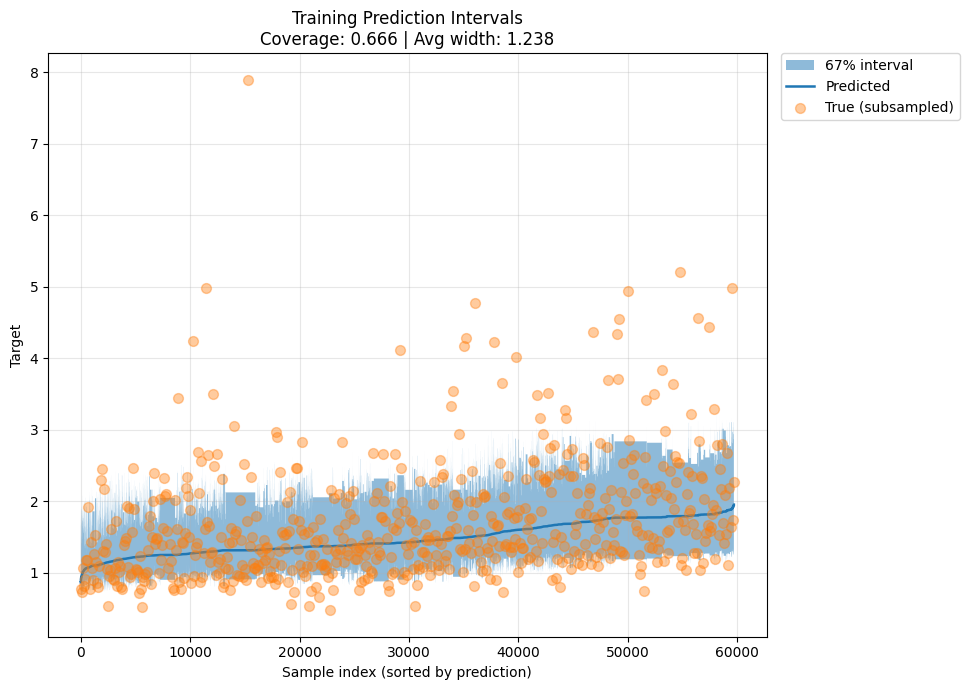

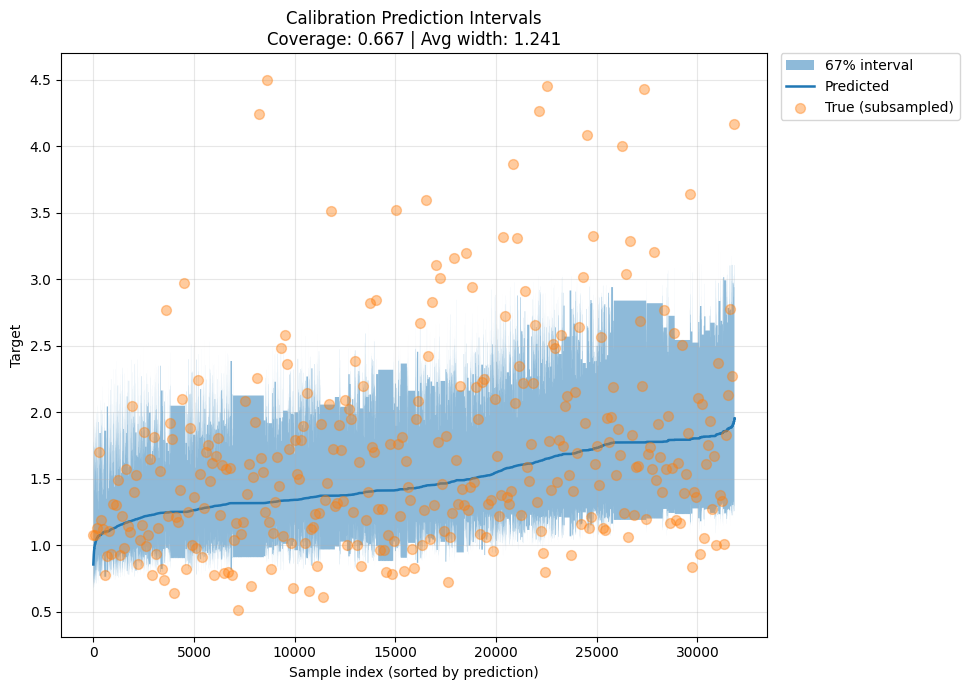

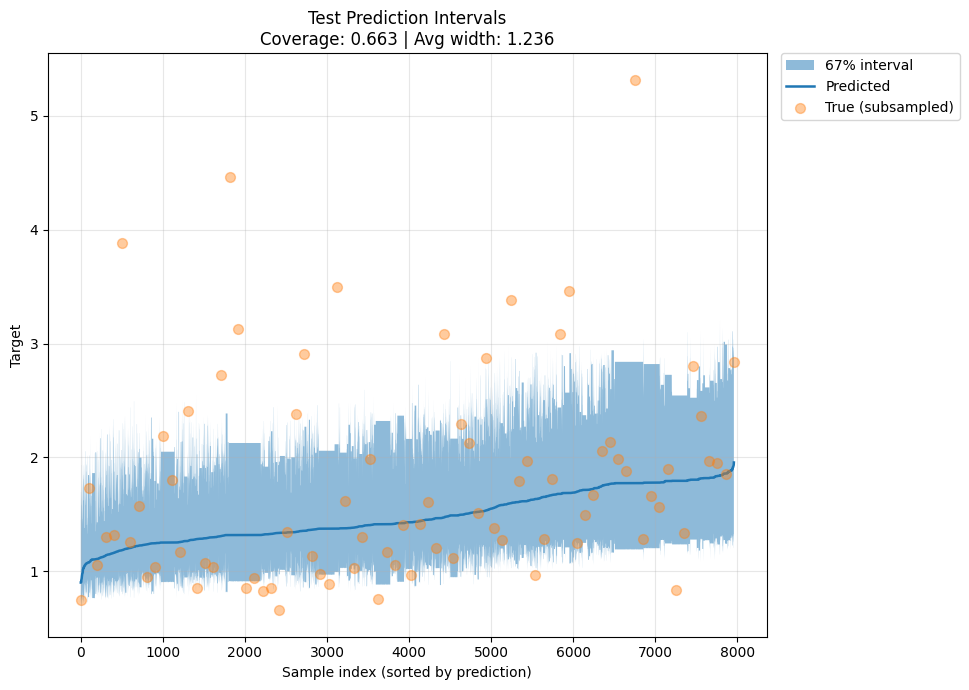

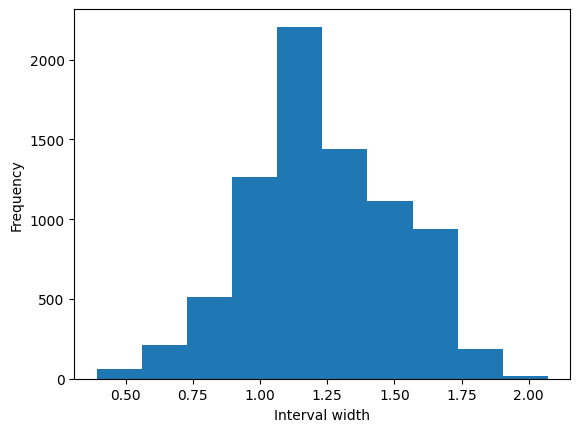

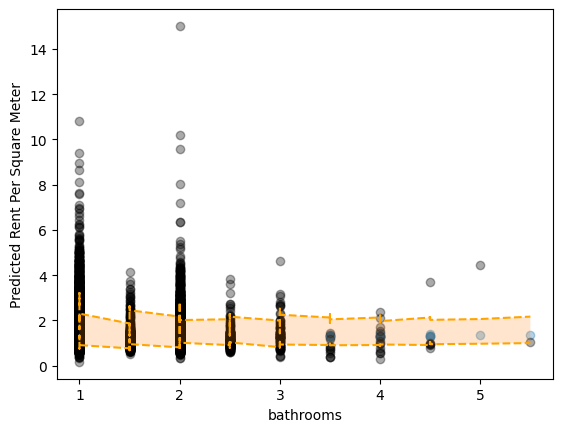

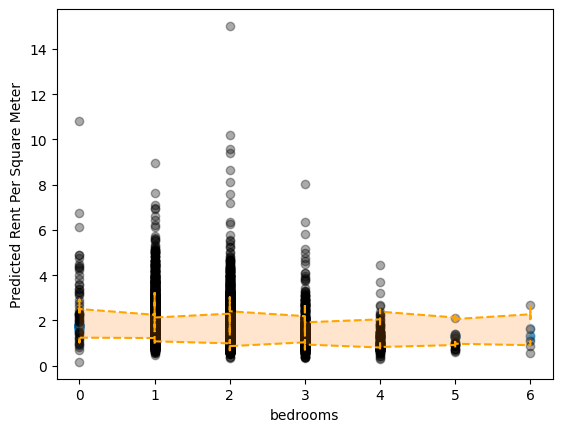

0

In [11]:
main()